# Galaxy photometry

**Version 0.1**

Today our goal is to compute the 1D radial profile of a simulated galaxy. While many software packages exist to do this, we will build this same functionality from scratch. Following this, we will be able to fit a radial profile to a galaxy image and measure its size. In practice, this problem is more complicated, but this example is, nevertheless, instructive.

* * *

By M Alpaslan (NYU) & AA Miller (CIERA/Northwestern & Adler)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import visualization as aviz

%matplotlib inline

## Problem 1) Visualize the Galaxy Image Data

The simulated galaxy for today's problem comes from the [Illustris Simulation](http://www.illustris-project.org), which is a large cosmological simulation of galaxy formation.

Download the fits image for our simulated galaxy: https://northwestern.box.com/s/a8qp2afv6ed9r36v0y0vyc3vf82s1bw0

(*Note* - The Illustris team has made simulated images of many different galaxies [available](http://www.illustris-project.org/galaxy_obs/).)

**Problem 1a**

Using your favorite tool, display an image of the galaxy using a logarithmic stretch. Do you notice anything unusual about the image?

/Users/jrobinson/anaconda/envs/DSFP/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/Users/jrobinson/anaconda/envs/DSFP/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


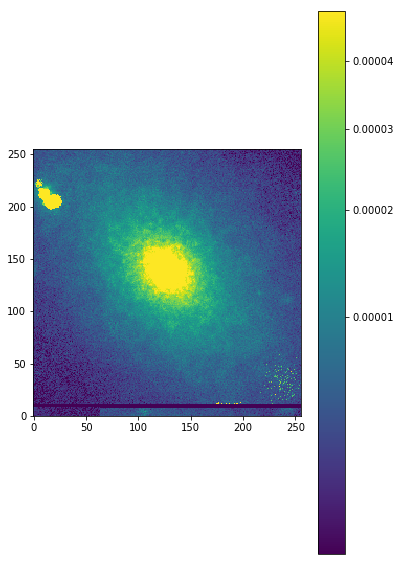

In [2]:
gal_im = fits.getdata('/Users/jrobinson/Google Drive/QUB PhD/LSST/Baltimore Jan 2018/galaxy.fits') # complete

# complete
# complete
#plt.imshow(gal_im)

#plt.colorbar()
#plt.tight_layout()

norm = aviz.ImageNormalize(gal_im, 
                           interval=aviz.PercentileInterval(95), 
                           #stretch=aviz.LogStretch())
                           stretch=aviz.SqrtStretch())

fig, ax = plt.subplots(1,1, figsize=(6,10))
aim = ax.imshow(gal_im, norm=norm, origin='lower')
plt.colorbar(aim)

**Problem 1b** 

Plot a histogram of the $\log$ of the pixel values in the simulated image.

*Hint* - you will likely want more than the `matplotlib` default number of bins.

In [3]:
print(gal_im)
print(np.mean(gal_im))
flat_im=np.ndarray.flatten(gal_im)
print(flat_im)
print(len(flat_im))


[[  1.40409497e-06   1.23375924e-06   1.16131582e-06 ...,   3.38868108e-06
    2.08336655e-06   2.43124509e-06]
 [  3.65412802e-06   2.03084778e-06   2.20613992e-06 ...,   2.43238469e-06
    9.05579952e-07   2.35961079e-06]
 [  2.13798353e-06   2.14721740e-06   1.69928967e-06 ...,   3.10251380e-06
    2.68991698e-06   1.31247566e-06]
 ..., 
 [  3.87839418e-06   3.08650806e-06   4.00288491e-06 ...,   1.18674507e-06
    1.32005778e-06   1.56045360e-06]
 [  3.74284991e-06   3.93335449e-06   3.23047516e-06 ...,   9.55860514e-07
    1.83221334e-06   3.62964300e-07]
 [  3.90415926e-06   3.59309479e-06   6.73499608e-06 ...,   1.64871221e-06
    1.80002553e-06   1.98883117e-06]]
0.00198484
[  1.40409497e-06   1.23375924e-06   1.16131582e-06 ...,   1.64871221e-06
   1.80002553e-06   1.98883117e-06]
65536


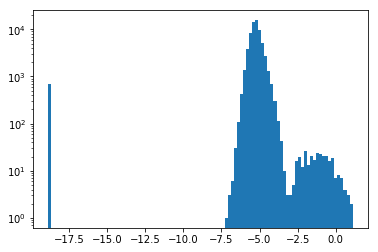

In [4]:
plt.hist(np.log10(flat_im),bins=100) # complete
plt.yscale("log")

**Problem 1c** 

Informed by your histogram, replace any highly discrepant pixels within the image with the median pixel value for the image.

*Hint* - plot the results to confirm this operation occurred as expected.

*Note* - this procedure is strongly discouraged with real data: if weird things are happening in an image there is a reason, and it is best to understand the origins of the peculiarities. For our current purposes, this step will simplify our analysis.

[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]


/Users/jrobinson/anaconda/envs/DSFP/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/Users/jrobinson/anaconda/envs/DSFP/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


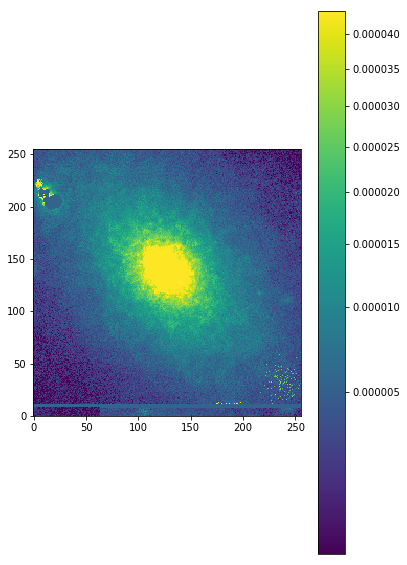

In [5]:
median_pix=(np.median(flat_im))

#remove lower pixels (in log10)
gal_im_log=np.log10(gal_im)
lowcut=-17.5
highcut=-2.5

unusual_pix1 = (gal_im_log<lowcut)# and (gal_im_log>highcut) # complete
unusual_pix2 = (gal_im_log>highcut)

unusual_pix=unusual_pix1+unusual_pix2

print(unusual_pix)
gal_im_log[unusual_pix]=np.log10(median_pix)

gal_median_filt = 10**gal_im_log

norm = aviz.ImageNormalize(gal_median_filt, 
                           interval=aviz.PercentileInterval(95), 
                           #stretch=aviz.LogStretch())
                           stretch=aviz.SqrtStretch())

fig, ax = plt.subplots(1,1, figsize=(6,10))
aim = ax.imshow(gal_median_filt, norm=norm, origin='lower')
plt.colorbar(aim)

#plt.tight_layout()

## Problem 2) Measuring Radial Intensities

Before we can measure the radial profile of this galaxy, we need to compute the flux intensity at a given radius. By convention, this is done by computing the mean flux along an ellipse centered on the galaxy (where the "radius" in this case is the semi-major axis).

An ellipse with arbitrary centroid and rotation angle can be described as 

$$ \frac{((x-h)\cos{\theta} - (y-k)\sin{\theta})^2}{a^2} + \frac{((x-h)\sin{\theta} + (y-k)\cos{\theta})^2}{b^2} = 1,$$

where $h, k, a, b, \theta$ are the x centroid, y centroid, semi-major axis, semi-minor axes, and the rotation angle of the elipse, respectively.

This can be re-written as (it's worth checking this on the board or scratch paper):

$$\left(\frac{\sin^2{\theta}}{a^2} + \frac{\cos^2{\theta}}{b^2}\right)y^2 + \left(-2\frac{((x-h)\cos{\theta} + k\sin{\theta})\sin{\theta}}{a^2} + 2\frac{((x-h)\sin{\theta} - k\cos{\theta})\cos{\theta}}{b^2}\right)y + \left(\frac{((x-h)\cos{\theta} + k\sin{\theta})^2}{a^2} + \frac{((x-h)\sin{\theta} - k\cos{\theta})^2}{b^2} - 1\right) = 0$$

**Problem 2a**

Write a function to solve for $y$ given $x$ and the ellipse parameters.

*Hint* - the function [`np.roots`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.roots.html) may be helpful.

In [12]:
def y_ellipse(x, h, k, a, b, theta):
    
    '''#solve the quadratic A*y^2 + B*y + C = 0
    A=((np.sin(theta)**2.0)/(a*2.0))+((np.cos(theta)**2.0)/(b*2.0))
    B=-2.0*(((((x-h)*np.cos(theta))+(k*np.sin(theta)))*np.sin(theta))/(a**2.0))
    +2.0*(((((x-h)*np.sin(theta))+(k*np.cos(theta)))*np.cos(theta))/(b**2.0))
    C=((((x-h)*np.cos(theta))+(k*np.sin(theta)))/a)**2.0 + ((((x-h)*np.sin(theta))+(k*np.cos(theta)))/b)**2.0 -1
    #print(A,B,C)
    #roots='''
    
    term1 = np.sin(theta)**2/(a **2) + np.cos(theta)**2/(b**2)
    term2 = -2 * ((x - h)*np.cos(theta) + k * np.sin(theta))*np.sin(theta)/a**2

    term3 = +2 * ((x - h)*np.sin(theta) - k * np.cos(theta))*np.cos(theta)/b**2
    term4 = ((x - h)*np.cos(theta) + k * np.sin(theta))**2/a**2
    term5 = ((x - h)*np.sin(theta) - k * np.cos(theta))**2/b **2
       
    A = term1
    B = term2 + term3
    C = term4 + term5 - 1

   
    return np.roots([A,B,C])

**Problem 2b**

Plot an elipse using your equation with $h = 0$, $k = 0$, $a = 4$, $b = 2$, and $\theta = \pi/6$.

*Hint* - most of this code has been provided for you.

(-4, 4)

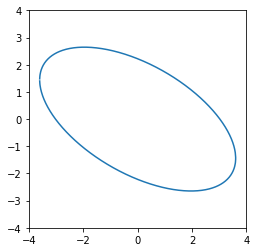

In [17]:
x_grid = np.linspace(-3.605, 3.605, 1000)
y_vals = np.vstack((np.empty_like(x_grid), np.empty_like(x_grid)))

h=0
k=0
a=4
b=2
theta=np.pi/6

for x_num, x in enumerate(x_grid):
    roots = y_ellipse(x,h,k,a,b,theta) # complete
    #print(roots)
    
    y_vals[:,x_num] = np.sort(roots)
    #print(y_vals)
    
    
plt.plot(np.append(x_grid, x_grid[::-1]), np.append(y_vals[0], y_vals[1][::-1]))
plt.axes().set_aspect('equal')
plt.xlim(-4, 4)
plt.ylim(-4, 4)

In [20]:
x_ell = np.append(x_grid, x_grid[::-1])
y_ell = np.append(y_vals[0], y_vals[1][::-1])

print(len(x_ell))
print(len(y_ell))

2000
2000


**Problem 2c**

Write a function to measure the average flux of every pixel in the image that is intersected by an ellipse with parameters $k, h, a, b, \theta$.

*Hint* - `np.floor()` will be useful for selecting the correct pixel.

*Hint 2* - brute force is not elegant, but it is sufficient as long as you throw away imaginary solutions.

In [24]:
#intsection means every pixel touching border of ellipse

def mean_radial_flux(im_data, h, k, a, b, theta):
    
    print(len(im_data))
    x_grid = np.arange(0, len(im_data))
    print(x_grid,len(x_grid))
    # complete
    # complete

    # complete
    # complete
    # complete
    # complete

    return # complete

In [25]:
mean_radial_flux(gal_im, h, k, a, b, theta)

256
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 24

For this and the remaining problems, assume that the galaxy is centered at (x, y) = (128, 138), that the ellipticity (1 - b/a) is fixed at 0.3, and that $\theta = 0.8377$. [In principle we could ask you to determine each of these values, but that is outside the scope of the current problem.]

**Problem 2d** 

Measure the mean "radial" flux of the galaxy at $a = 5$ and $a = 20$. Do these answers make sense? 

In [9]:
a5_flux = # complete
a20_flux = # complete

print("The mean flux at 5 pixels is {:.6f}".format( # complete
print("The mean flux at 20 pixels is {:.6f}".format( # complete

SyntaxError: invalid syntax (<ipython-input-9-2c711d597f20>, line 1)

**Problem 2e**

Plot the "mean radial profile" of the galaxy.

*Hint* - when choosing a grid of radii to measure, recall that the function does not make sub-pixel estimates of the flux. 

In [ ]:
r_grid = # complete
mean_rad_prof = # complete
for # complete

plt.plot( # complete

## Problem 3) Sersic Profile

The Sersic profile for galaxies can be written as: 

$$\ln I(R) = \ln I_0 - kR^{1/n},$$

where $I$ is the intensity (or flux), $I_0$ is the intensity at $R = 0$, $k$ is a normalization constant, and $n$ is the "Sersic index", which describes the curvature of the light profile.

We will now use a non-linear optimization routine from `scipy.optimize` to determine the value of the Sersic index.

**Problem 3a**

Create a function `squared_error()` that calculates the sum of the squared difference between $\ln I(R)$ and $\ln I_0 - kR^{1/n}$.

*Hint* - the 3 unknown parameters ($I_0$, $k$, and $n$) should be passed to the function as a single tuple called `params`.

In [ ]:
def squared_error( # complete
    
    # complete
    # complete
    # complete

**Problem 3b**

Using the `L-BFGS-B` method of `scipy.optimize.minimize()`, determine the value of the Sersic index.

*Hint* - you will want to provide a reasonable first guess along with bounds for the minimization function.

In [ ]:
from scipy.optimize import minimize
res = minimize( # complete
                # complete
                # complete

print("The Sersic index is {:.3f}".format( # complete

## Challenge Problem

The image that we have been working with reflects the full sensitivity of the Illustris simulation. Ground based images are observed through the atmosphere. Convolve the image with a PSF (assume a circular gaussian with FWHM = 12 pixels) and re-measure the Sersic index. How does your answer compare?

In [ ]:
# complete